# Greenberger–Horne–Zeilinger (GHZ) State Fidelity

The aim of this benchmark is to show whether a GHZ state with high enough fidelity can be prepared such that the state is genuinely multipartite entangled. One can show that a fidelity larger than 0.5 is a sufficient condition (see Leibfried, D. et al., Creation of a six-atom ‘Schrödinger cat’ state. Nature 438, 639–642 (2005))

The benchmark currently offers two methods to estimate the fidelity:
* Multiple quantum coherences (G. J. Mooney et al., Generation and verification of 27-qubit Greenberger-Horne-Zeilinger states in a superconducting quantum computer, J. Phys. Commun. 5, 095004 (2021))
* Randomized measurements (Elben, A. et al., Statistical correlations between locally randomized measurements: A toolbox for probing entanglement in many-body quantum states, Phys. Rev. A 99, 052323 (2019))

Additionally, for a given set of $n$ qubits, different circuits can be applied which lead to the same GHZ state. Currently there are the following implementations:
* "naive": The textbook ciruit of depth $n$, which starts from a Hadamrd gate on one qubit and entangles each additional qubit with a CNOT operation from the first.
* "log_depth": A logarithmic depth circuit utilizing parallel CNOT applications. Either the method in Cruz et al. https://arxiv.org/abs/1807.05572 or the method in Mooney et al. https://arxiv.org/abs/2101.08946 is used, depending on which yields the lower depth or the lower number of 2-qubit gates. 
* "tree": An in-house logarithmic depth circuit utilizing calibration data of the CZ-fidelities and a tree-graph algorithm to find a circuit with minimal depth and high fidelity 2-qubit gates. 

Note that the first two methods will always give the same circuit for the same qubit layout (and the same coupling map), while the "tree" method relies on the latest calibration fidelities and can give different circuits on different days. 
Thus for consistent comparisons one of the first two methods should be chosen, while for the best results, i.e. the largest possible GME entangled GHZ state, the tree-method is preferable.

In [1]:
from iqm.benchmarks.entanglement.ghz import *
from iqm.qiskit_iqm import IQMProvider
iqm_server_url = "https://cocos.resonance.meetiqm.com/garnet"
provider = IQMProvider(iqm_server_url)
backend = provider.get_backend()

## Definition of the benchmark configuration
The important parameters are:
* ``custom_qubits_array``: A ``list[list[int]]`` which includes all qubit layouts on which the benchmark is run.
* ``qubit_counts``:  In case ``custom_qubits_array`` is not set, this ``list[int]``specifies for which numbers of qubits the benchamarks is executed. The qubits are then automatically selected. In case ``custom_qubits_array`` is also set, ``qubit_counts`` is ignored and the qubit conts are the lengths of the qubit layouts in ``custom_qubits_array``.
* ``shots``: The number of shots for the fidelity measurement.
* ``fidelity_routine``: Either "coherences" or "randomized_measurements".
* ``rem``: Boolean value that controls whether readout error mitigation is used.
* ``mit_shots``: Whenever rem=True, this parameter controls the total number of shots used to calibrate readout error mitgation.
* ``num_RMs``: The number of randomized measurement settings (only necessary when choosing ``fidelity_routine=randomized_measurements``).

In [4]:
# Simple configuration
MINIMAL_GHZ = GHZConfiguration(
    state_generation_routine="tree",
    qubit_counts = [5,10,15,20],
    shots=1000,
    fidelity_routine="coherences", 
    rem=True,
    mit_shots=1000,
    use_dd = True,
)

For achieving best results it is currently recommended to choose the qubit layouts by hand. To think about which qubit layouts to use, the following visualization of the connectivity and CZ fidelities is helpful. 

Requirements: 
* Access to the backend, in this example IQM Garnet.
* An access token environment variable needs to be set via ``os.environ["IQM_TOKEN"] = <your_token>``.

Use of the plot:
* If the ``qubit_layouts`` argument is provided, the selected qubits are marked in orange.
* CZ errors are indicated with edge width, **thinner is better**, where the edge width is given by $w_{ij} = - \mathrm{log}(\mathcal{F}_{\mathrm{CZ}}^{ij})$.
* Each edge is also labeled with the width value. 
* Some graph layouts are predefined to match the layout as shown in IQM-Resonance. If the layout is not predefined, a graph in grid or star layout will be automatically generated, dependeing on the backend. Automatically generated graphs might need to be rerun a few times until a nice node layout is found. 

Check if access token environment variable is set: True


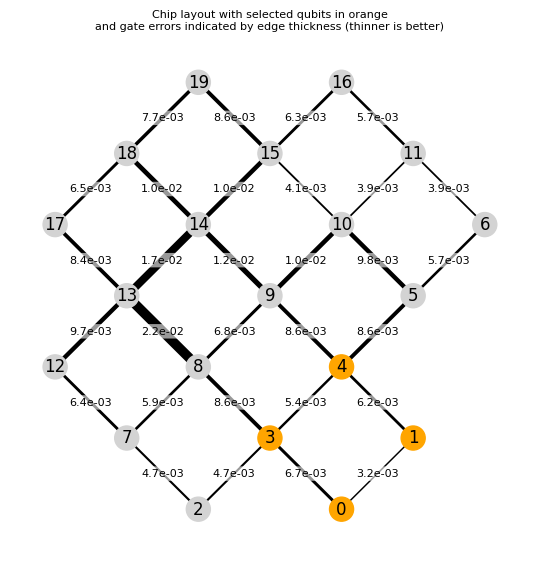

In [8]:
from iqm.benchmarks.utils_plots import plot_layout_fidelity_graph
import os

print(f"Check if access token environment variable is set: {'IQM_TOKEN' in os.environ}")
cal_url = f"https://api.resonance.meetiqm.com/quantum-computers/v1/garnet/calibrations" 
qubit_layouts = [[0,1,3,4]]
fig = plot_layout_fidelity_graph(cal_url, qubit_layouts = qubit_layouts, station = "garnet")

## Running the benchmark

In [9]:
benchmark_ghz = GHZBenchmark(backend, MINIMAL_GHZ)
run_ghz = benchmark_ghz.run()

2025-04-08 15:12:01,744 - iqm.benchmarks.logging_config - WARNING - Since no custom qubit layouts were specified, the qubits will be automatically selected, likely leading to suboptimal fidelities.
2025-04-08 15:12:01,747 - iqm.benchmarks.logging_config - INFO - Now generating a 5-qubit GHZ state on qubits [1, 0, 4, 3, 5]
2025-04-08 15:12:01,749 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQM Backend with optimization level 3, sabre routing method including SQG optimization all circuits
2025-04-08 15:12:02,727 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQM Backend with optimization level 3, sabre routing method including SQG optimization all circuits
2025-04-08 15:12:02,894 - iqm.benchmarks.logging_config - INFO - Submitting batch with 13 circuits corresponding to qubits [1, 0, 4, 3, 5]
C:\Users\RaphaelBrieger\miniconda3\envs\iqm-benchmarks\Lib\site-packages\iqm\qiskit_iqm\iqm_provider.py:177: UserWarning: Unknown backend option(s): {'calibrat

In [10]:
result = benchmark_ghz.analyze()

## Accessing the results
To see individual fidelitiy and uncertainty values of a given qubit layout, one can filter the ``result.observations``-list by layout as shown below. 

The plot allows a comparison of all layout results with and without REM, where the data point description labels "L0", "L1", ... enumerate the layouts in the order defined in the configuration.

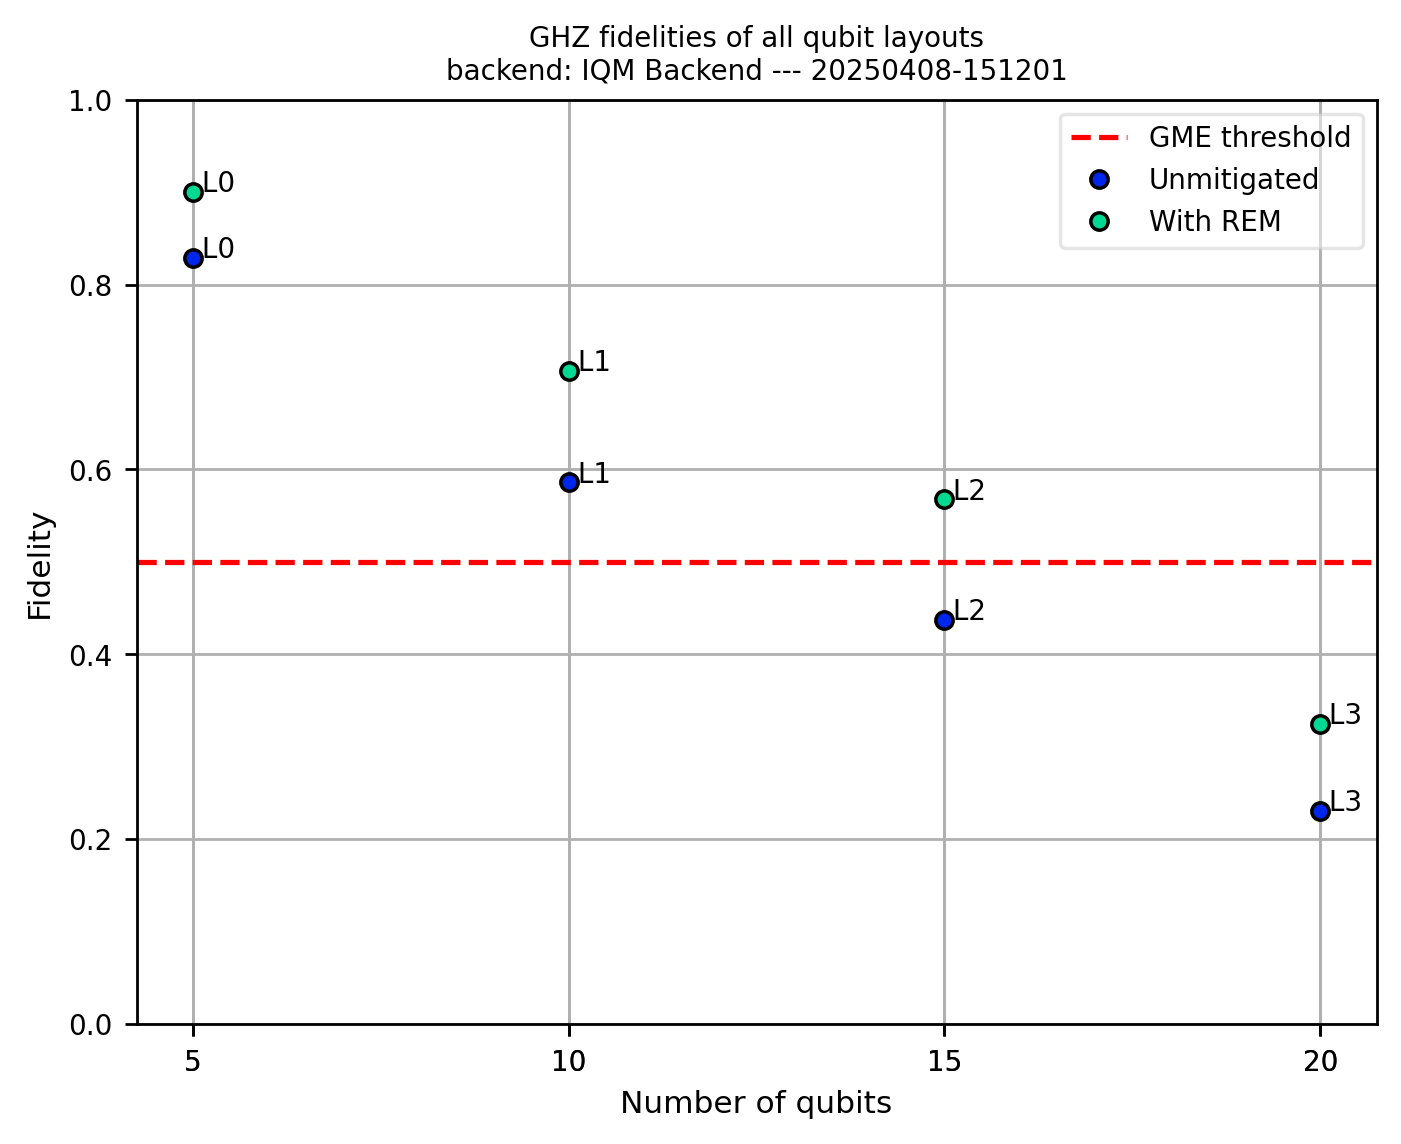

In [11]:
qubit_layout = [0,1,3]
for observation in result.observations:
    if observation.identifier.string_identifier == str(qubit_layout):
        print(f"{observation.name}: {observation.value} +/- {observation.uncertainty}")
result.plot_all()